This requires you to write a 2D GAN game. I let you to get into the topic yourself, whitout any explonations from my side. You can watch internet, read papers and tutorials (fun, fun, fun).

### Homework

I want you to implement a simple 2D GAN game. The kind of animation, I want to see is like in [this video](https://www.youtube.com/watch?v=KeJINHjyzOU&feature=youtu.be&t=15m38s) at 15:36 or in [here](https://habrahabr.ru/post/275429/) **but in 2D**. You can google, search code at github, whatever, but the network should be based on TensoFlow.

Basically you will need to come up with true distribution $P$, say mixture of gaussians (surprise me), sample some data from it. Visualize it as a heatmap. To visualize $G$ density you can fix $N$ noise vectors $\{z_i\} \quad i=1,\dots, N$ and draw a circle for each $G(z_i)$. It is also funny to visualize discriminator as a vector field (can be done with `plt.arrow`, `plt.quiver` plot). Look how it should be in the middle of [this page](http://www.inference.vc/an-alternative-update-rule-for-generative-adversarial-networks/).

Please, make sure your code works if 'Run All' is pressed and it draws some animation.

Good luck!

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import clear_output

/home/hov/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
init = tf.initializers.random_uniform(-0.5,0.5)

In [3]:
def discriminator(inpt, reuse, name):
    with tf.variable_scope("Discriminator", reuse=reuse):
        dl1 = tf.layers.dense(inpt, 10, activation=tf.nn.relu, name="dl1", kernel_initializer=init)
        dl2 = tf.layers.dense( dl1, 7, activation=tf.nn.relu, name="dl2", kernel_initializer=init)
        dl3 = tf.layers.dense( dl2, 5, activation=tf.nn.relu, name="dl3", kernel_initializer=init)
        dis = tf.layers.dense( dl3, 1, name="dis")
        prob= tf.sigmoid(dis, name)
    return prob

In [4]:
inX = tf.placeholder(tf.float32, shape=[None, 2], name="X")
z  = tf.placeholder(tf.float32, shape=[None, 2], name="z")

In [5]:
dis = discriminator(inX, False, "discriminator")

In [6]:
with tf.variable_scope("Generator"):

    gl1 = tf.layers.dense(z,   10, activation=tf.nn.leaky_relu, name="gl1", kernel_initializer=init)
    gl2 = tf.layers.dense(gl1, 10, activation=tf.nn.leaky_relu, name="gl2", kernel_initializer=init)
    gl3 = tf.layers.dense(gl2, 10, activation=tf.nn.leaky_relu, name="gl3", kernel_initializer=init)
    gl4 = tf.layers.dense(gl3, 10, activation=tf.nn.leaky_relu, name="gl4", kernel_initializer=init)
    gen = tf.layers.dense(gl4, 2, name="gen")
    
combined = discriminator(gen, True, "combined")

In [7]:
gen_vars  = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="Generator")
disc_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="Discriminator")

In [8]:
gloss = tf.reduce_mean(tf.log(1 - combined))

In [9]:
dloss = -tf.reduce_mean(tf.log(dis) + tf.log(1 - combined))

In [10]:
writer = tf.summary.FileWriter('log/')
writer.add_graph(tf.get_default_graph())
writer.close()

In [11]:
train_gen = tf.train.AdamOptimizer(1e-2).minimize(gloss, var_list=gen_vars)
train_dis = tf.train.AdamOptimizer(1e-2).minimize(dloss, var_list=disc_vars)

In [12]:
data = np.concatenate((np.random.normal(-5, 3, size=(2000,2)),np.random.normal(3, 1.5, size=(1000,2))))

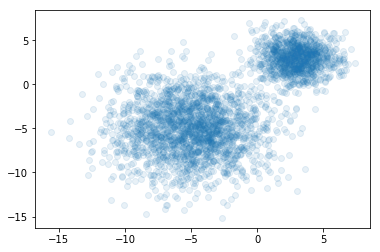

In [13]:
plt.scatter(data[:,0],data[:,1],alpha=0.1)

In [14]:
def sampleNoise(batch_size,rng=[-100,100]):
    return np.random.uniform(rng[0], rng[1], (batch_size, 2))

In [15]:
def generate_data_for_dist(batch_size):
    real_data = data[np.random.choice(len(data), batch_size)]
    generated_data = sess.run(gen, feed_dict={})
    
    y = np.ones((2*batch_size, 1))
    y[:batch_size] = 0
    return np.concatenate((real_data, generated_data)),y

In [16]:
if "sess" in dir():
    sess.close()
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [17]:
l = np.linspace(-10, 10, 100)
meshgrid = np.meshgrid(l, l)
l2 = np.array(meshgrid).T.reshape(-1, 2)

In [18]:
from mpl_toolkits.mplot3d.axes3d import Axes3D

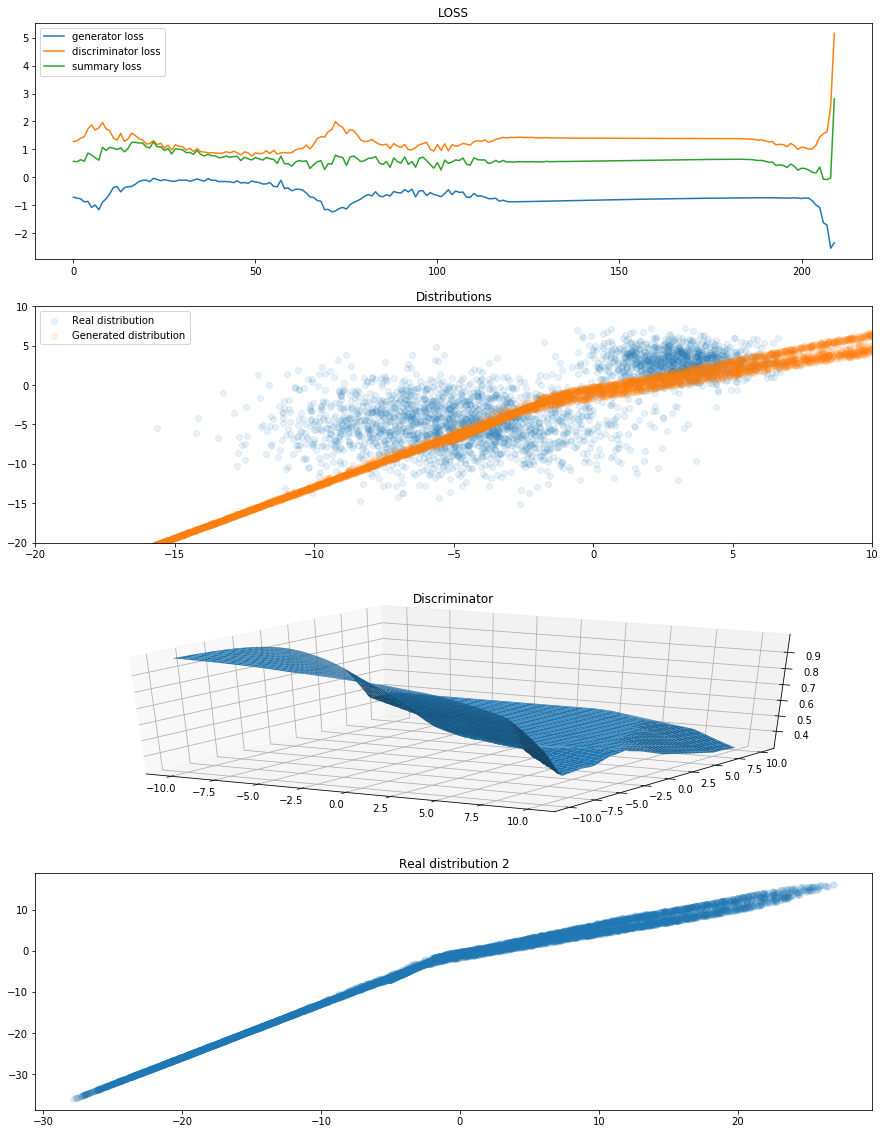

gen  -2.3492985
dis  5.1595545
epoch 210
2.8329515


In [19]:
eps=1e-100
batch_size = 20

glosshist=[]
dlosshist=[]

# with tf.device("/device:GPU:0"):
while len(glosshist)<2 or np.abs(glosshist[-1]-glosshist[-2]) + np.abs(dlosshist[-1]-dlosshist[-2]) > eps:
    X = data[np.random.choice(len(data),batch_size)]

    _, dis_train_err = sess.run([train_dis, dloss], feed_dict={inX: X, z: sampleNoise(batch_size)})
    _, gen_train_err = sess.run([train_gen, gloss], feed_dict={inX: X, z: sampleNoise(batch_size)})

    dlosshist.append(dis_train_err)
    glosshist.append(gen_train_err)

    out = sess.run(dis, feed_dict={inX: l2})
    generated = sess.run(gen, feed_dict={z: sampleNoise(10000,[-120,120])})

    if len(glosshist)%10 == 0:
        glh = np.array(glosshist[-500:])
        dlh = np.array(dlosshist[-500:])

        clear_output(wait=True)
        fig = plt.figure(figsize=(15,20))

        plt.subplot(411)
        plt.title("LOSS")
        plt.plot(glh, label="generator loss")
        plt.plot(dlh, label="discriminator loss")
        plt.plot(glh + dlh, label="summary loss")
        plt.legend()

        plt.subplot(412)
        plt.title("Distributions")
        plt.scatter(data[:,0], data[:,1], alpha=0.1, label="Real distribution")
        plt.scatter(generated[:,0], generated[:,1], alpha=0.1, label="Generated distribution")
        plt.legend()
        plt.xlim(-20, 10)
        plt.ylim(-20, 10)

        ax = fig.add_subplot(4, 1, 3, projection='3d')
        plt.title("Discriminator")
        surf = ax.plot_surface(meshgrid[0], meshgrid[1], out.reshape(meshgrid[0].shape))

        plt.subplot(414)
        plt.title("Real distribution 2")
        plt.scatter(generated[:,0], generated[:,1], alpha=0.1);

        plt.show()

        print("gen ", gen_train_err)
        print("dis ", dis_train_err)
        print("epoch", len(glosshist))
        print(np.abs(glosshist[-1]-glosshist[-2]) + np.abs(dlosshist[-1]-dlosshist[-2]))

In [20]:
len(glosshist)

213

In [21]:
from IPython.display import Audio, display

def allDone():
    display(Audio(url='https://sound.peal.io/ps/audios/000/000/537/original/woo_vu_luvub_dub_dub.wav', 
                  autoplay=True))

In [22]:
allDone()

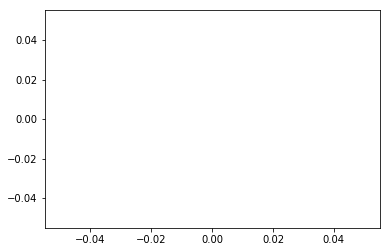

In [27]:
generated = sess.run(gen, feed_dict={z: sampleNoise(10000,[-120,120])})
plt.scatter(generated[:,0], generated[:,1], alpha=0.1);

In [32]:
(generated-generated).sum()>10

False

In [24]:
a = sess.run(gen_vars)

In [25]:
flatten = np.concatenate([i.flatten() for i in a])

/home/hov/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)
/home/hov/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


ValueError: max must be larger than min in range parameter.

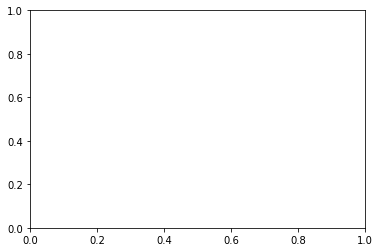

In [26]:
plt.hist(flatten)

In [ ]:
a[-1]

In [ ]:
a[-2]